<a href="https://colab.research.google.com/github/karma3983/PubNeu/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving test_data.csv to test_data.csv


In [ ]:
import numpy as np # 数値計算ライブラリ
import csv # Excelファイル読み込み用
import matplotlib.pyplot as plt # グラフ作成用
%matplotlib inline

# CSVの読み込み

In [ ]:
def load_csv(file_name):
    with open(file_name) as f:
        reader = csv.reader(f)
        return np.array([record for record in reader]) # 内包表記（リスト）

## test data の読み込み

In [ ]:
# #test_data
def set_data_test():
    datas = load_csv('test_data.csv') # 読み込み

    datas = datas[1:]

    x_trains = datas[:, :-1].astype(np.float32) # 訓練データ
    t_trains_text = datas[:, -1:] # 教師データ(ラベル)

    t_trains = []
    for t in t_trains_text:
        if t == 'A':
            t_trains.append(0)
        elif t == 'B':
            t_trains.append(1)
        else:
            t_trains.append(2) # C

    # 本来なら訓練データとテストデータを分けるべきだが、今回は同一データとする
    x_tests = x_trains
    t_tests = t_trains

    return x_trains, t_trains, x_tests, t_tests # 訓練データ、教師データ

# one-hot 表現に変換

In [ ]:
'''one-hot表現'''

def one_hot_t(n, t):
    nums = np.arange(n)
    return np.where(nums==t, 1, 0)

# 活性化関数

## Sigmoid

In [ ]:
def sigmoid(u): # シグモイド関数　1/(1+exp(-x))
    return 1.0 / (1.0 + np.exp(-1 * u))

In [ ]:
def diff_sigmoid(u): # シグモイド関数　微分
    return sigmoid(u) * (1.0 - sigmoid(u))

## ReLU

In [ ]:
def relu(u):
    return np.maximum(0.0, u) # 0とu　どちらが大きいか

In [ ]:
def diff_relu(u):
    return np.where(u > 0.0, 1.0, 0.0) # 0より大きいなら1、小さいなら0

## Leaky ReLU

In [ ]:
def leaky_relu(u, alpha=0.01):
    return np.where(u > 0.0, u, alpha * u) # 0より大きいならu、小さいなら0.01*u

In [ ]:
def diff_leaky_relu(u, alpha=0.01):
    return np.where(u > 0.0, 1.0, alpha)  #0より大きいなら1、小さいなら0.01

## Swish

In [ ]:
def swish(u):
    return u * sigmoid(u) # 入力*シグモイド関数

In [ ]:
def diff_swish(u):
    return swish(u) + (sigmoid(u) * (1.0 - swish(u))) # 導関数の式

## Mish

In [ ]:
def mish(u):

    def softplus(u): # ソフトプラス関数
        return np.log(1.0 + np.exp(u))

    return u * np.tanh(softplus(u))

In [ ]:
def diff_mish(u):

    def omega(u):
        return 4*(u+1) + 4*np.exp(2*u) + np.exp(3*u) + np.exp(u)*(4*u+6)

    def delta(u):
        return 2*np.exp(u) + np.exp(2*u) + 2

    return np.exp(u) * omega(u) / delta(u)**2

## 活性化関数の呼び出し

In [ ]:
def activate(u, act_func): # 入力値u、何の活性化関数かact_func
    if act_func == 'sigmoid':
        return sigmoid(u)
    elif act_func == 'relu':
        return relu(u)
    elif act_func == 'leaky_relu':
        return leaky_relu(u)
    elif act_func == 'swish':
        return swish(u)
    elif act_func == 'mish':
        return mish(u)

In [ ]:
def diff_activate(u, act_func):
    if act_func == 'sigmoid':
        return diff_sigmoid(u)
    elif act_func == 'relu':
        return diff_relu(u)
    elif act_func == 'leaky_relu':
        return diff_leaky_relu(u)
    elif act_func == 'swish':
        return diff_swish(u)
    elif act_func == 'mish':
        return diff_mish(u)

## Softmax 関数

In [ ]:
def softmax(u):
    u_max = max(u) # exp(x)はすぐオーバフローするので、一番大きいものから引く
    ux = np.exp(u - u_max)
    return ux / np.sum(ux) # exp(u)/Σexp(u)

## 損失関数（クロスエントロピー誤差）

In [ ]:
'''損失関数（クロスエントロピー誤差）'''

def E(z, t):
    logz = np.log(z + 0.0000001) # zは0~1なので、log(0)のエラーを回避する
    t_logz = t * logz
    return -1 * np.sum(t_logz)

# 初期化処理

In [ ]:
'''重みの初期化'''

def initialize_w(count_unit, count_input, init_type):
    if init_type == 'He':
        return np.random.randn(count_unit, count_input) * np.sqrt(2 / count_input)      #Heの初期値
    elif init_type == 'Xavier':
        return np.random.randn(count_unit, count_input) / np.sqrt(count_unit)          #Xavierの初期値

In [ ]:
'''重みとバイアスの初期値を設定'''

def set_w(count_data, count_h1, count_h2, count_out):

    w_h1 = initialize_w(count_h1, count_data, "He")
    b_h1 = np.zeros(count_h1)

    w_h2 = initialize_w(count_h2, count_h1, "He")
    b_h2 = np.zeros(count_h2)

    w_out = initialize_w(count_out, count_h2, "Xavier")
    b_out = np.zeros(count_out)

    return w_h1, b_h1, w_h2, b_h2, w_out, b_out

# ハイパーパラメータ等の設定

In [ ]:
'''設定（設定を変更する場合はここを変更）'''

np.random.seed(1)           # ランダムのタネを固定

eta = 0.01                  # 学習率
max_epoch = 1000            # 最大エポック数(何回学習させるか)
min_loss = 0.01             # 最小誤差

target_data = 'test' # 何のデータを使用するか(今回はテストデータ)

# 活性化関数をひとつ選択
#act_func = 'sigmoid'
act_func = 'relu'
#act_func = 'leaky_relu'
#act_func = 'swish'
#act_func = 'mish'

In [ ]:
'''データの読み込みとユニット数の設定'''

if target_data == 'test': # テストデータ使用
    x_trains, t_trains, x_tests, t_tests = set_data_test() # 読み込み
    count_h1 = 3 # 隠れ層のユニット
    count_h2 = 2 # 隠れ層二層目のユニット
    count_out = 3 # 出力層(A,B,Cの三つ)

In [ ]:
'''重みとバイアスの初期化'''

w_h1, b_h1, w_h2, b_h2, w_out, b_out = set_w(x_trains.shape[1], count_h1, count_h2, count_out)

In [ ]:
x_trains # 訓練データ(x1とx2)

In [ ]:
t_trains # 教師データ(A=0,B=1,C=2)

# 学習

In [ ]:
'''学習フェーズ'''

## data_count = x_datas.shape[0]
data_count = x_trains.shape[0]

history = []
for i in range(max_epoch):
    loss = 0

    ''' # 消してもOK
    t0 = 0
    t1 = 0
    t2 = 0
    '''
    for data in range(data_count):
        ## 前回
        ## x = x_datas[data]
        ## t = one_hot_t(count_out, int(t_datas[data])) 

        x = x_trains[data]
        t = one_hot_t(count_out, int(t_trains[data]))
        
        '''順伝播''' #入力層から出力層に計算すること
        # 隠れ層1
        u_h1 = np.dot(w_h1, x) + b_h1 # 入力値に、隠れ層1の重みをかけて、バイアスを足す
        ## z_h1 = activate(u_h1)
        z_h1 = activate(u_h1, act_func) # 活性化関数を引数に
        
        # 隠れ層2
        u_h2 = np.dot(w_h2, z_h1) + b_h2
        ## z_h2 = activate(u_h2)
        z_h2 = activate(u_h2, act_func)
        
        # 出力層
        u_out = np.dot(w_out, z_h2) + b_out
        z_out = softmax(u_out) # ソフトマックス
        
        '''
        if t.argmax() == z_out.argmax():
            if t.argmax() == 0:
                t0 = 1
            elif t.argmax() == 1:
                t1 = 1
            elif t.argmax() == 2:
                t2 = 1
        '''
        
        # 損失値
        loss += E(z_out, t)
        
        '''逆伝播'''
        # 出力層
        delta_out = z_out - t
        dw_out = np.outer(delta_out, z_h2)
        db_out = delta_out
        
        # 隠れ層2
        ## delta_h2 = np.dot(w_out.T, delta_out) * diff_activate(u_h2)
        delta_h2 = np.dot(w_out.T, delta_out) * diff_activate(u_h2, act_func)
        dw_h2 = np.outer(delta_h2, z_h1)
        db_h2 = delta_h2
        
        # 隠れ層1
        ## delta_h1 = np.dot(w_h2.T, delta_h2) * diff_activate(u_h1)
        delta_h1 = np.dot(w_h2.T, delta_h2) * diff_activate(u_h1, act_func)
        dw_h1 = np.outer(delta_h1, x)
        db_h1 = delta_h1
        
        # 重みとバイアスの更新
        w_out -= (eta * dw_out)
        b_out -= (eta * db_out)
        w_h2 -= (eta * dw_h2)
        b_h2 -= (eta * db_h2)
        w_h1 -= (eta * dw_h1)
        b_h1 -= (eta * db_h1)
        
    loss /= data_count
    history.append(loss)
    
    if i % 10 == 0:
        print(f'i:{i} / loss:{loss}')
    
    # 前回
    '''
    # 全部正解したら処理を抜ける
    if (t0 + t1 + t2) == 3:
        print('ok')
        break
    '''
    
    # loss が 充分小さくなったら処理を抜ける
    if loss < min_loss:
        break
        
print(f'>> i:{i} / loss:{loss}')

i:0 / loss:1.257150794976698
i:10 / loss:0.5044669068197116
i:20 / loss:0.3228589609631314
i:30 / loss:0.23273352442107403
i:40 / loss:0.1688445083396269
i:50 / loss:0.12063933705368901
i:60 / loss:0.09027970739033402
i:70 / loss:0.07482541383925238
i:80 / loss:0.06270393083986951
i:90 / loss:0.05545407766406404
i:100 / loss:0.049960804418541255
i:110 / loss:0.04521606455968983
i:120 / loss:0.04029050956459274
i:130 / loss:0.0371588725205115
i:140 / loss:0.03548827145823615
i:150 / loss:0.03349145866726217
i:160 / loss:0.03126826600380495
i:170 / loss:0.029220773320275846
i:180 / loss:0.027319413622193187
i:190 / loss:0.02627582772751103
i:200 / loss:0.02274495918969264
i:210 / loss:0.023376522483159905
i:220 / loss:0.021164168843304125
i:230 / loss:0.019787854664422237
i:240 / loss:0.02077942083020437
i:250 / loss:0.01817329708970161
i:260 / loss:0.01868929582406792
i:270 / loss:0.0179161077786353
i:280 / loss:0.017576993436128573
i:290 / loss:0.016507990541321325
i:300 / loss:0.01583

In [ ]:
'''重みとバイアスの値を外部ファイルに保存'''

#np.savez('param_nn.npz', w_h1=w_h1, b_h1=b_h1, w_h2=w_h2, b_h2 = b_h2, w_out=w_out)

'重みとバイアスの値を外部ファイルに保存'

# テスト

In [ ]:
'''テスト'''

correct = 0
data_count = x_tests.shape[0]
uncorrect_indexes = []            # 不正解データのインデックス格納用
for idx in range(data_count):
    x = x_tests[idx]        
    t = one_hot_t(count_out, int(t_tests[idx]))
    
    # 順伝播
    u_h1 = np.dot(w_h1, x) + b_h1
    z_h1 = activate(u_h1, act_func)
    u_h2 = np.dot(w_h2, z_h1) + b_h2
    z_h2 = activate(u_h2, act_func)
    u_out = np.dot(w_out, z_h2) + b_out
    z_out = softmax(u_out)
    
    if t.argmax() == z_out.argmax():
        correct += 1
    else:
        uncorrect_indexes.append(idx)

accuracy = correct / data_count * 100
print(f'{correct}/{data_count} : accuracy:{accuracy}')

150/150 : accuracy:100.0


In [ ]:
'''不正解データのインデックス'''

uncorrect_indexes

[]

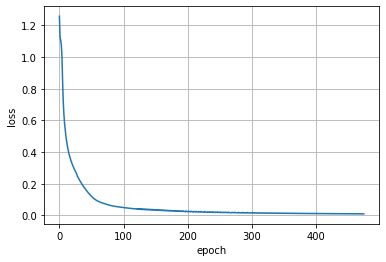

In [ ]:
'''誤差のグラフ表示'''

x = np.arange(len(history))
y = history

plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [ ]:
'''nn_test'''

index = 0
x = x_tests[index]

In [ ]:
x # 答えはC(=2)

array([1.8, 0.8], dtype=float32)

In [ ]:
'''推論'''

t = one_hot_t(count_out, int(t_tests[index]))
    
u_h1 = np.dot(w_h1, x) + b_h1
z_h1 = activate(u_h1, act_func)
u_h2 = np.dot(w_h2, z_h1) + b_h2
z_h2 = activate(u_h2, act_func)
u_out = np.dot(w_out, z_h2) + b_out
z_out = softmax(u_out)
    
print(f't:{t.argmax()} / nn_answer:{z_out.argmax()}')

t:2 / nn_answer:2


In [ ]:
'''推論（未知のデータ）'''

x = np.array([1.7, 2.0])

u_h1 = np.dot(w_h1, x) + b_h1
z_h1 = activate(u_h1, act_func)
u_h2 = np.dot(w_h2, z_h1) + b_h2
z_h2 = activate(u_h2, act_func)
u_out = np.dot(w_out, z_h2) + b_out
z_out = softmax(u_out)
    
print(f'nn_answer:{z_out.argmax()}')

nn_answer:1


In [ ]:
'''推論（未知のデータ）''' 

x = np.array([3.4, 1.0])

u_h1 = np.dot(w_h1, x) + b_h1
z_h1 = activate(u_h1, act_func)
u_h2 = np.dot(w_h2, z_h1) + b_h2
z_h2 = activate(u_h2, act_func)
u_out = np.dot(w_out, z_h2) + b_out
z_out = softmax(u_out)
    
print(f'nn_answer:{z_out.argmax()}')

nn_answer:2
